In [0]:
from google.colab import drive,files

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import librosa
import glob
import pickle
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

# Loading data

If data already exists in the pickle files then we will use the pickle file to get our input data. If it doesn't exist then we will load the files from the given path.

In [0]:
def getData(pickle_path , mag_pickle_path , input_data_path):
  if os.path.exists(pickle_path) and os.path.exists(mag_pickle_path):
    speech_list = pickle.load(open(pickle_path, 'rb' ))
    mag_speech_list = pickle.load(open(mag_pickle_path, 'rb' ))
    print('Pickle already exists! Extracting the data from the pickle')
    
    return speech_list , mag_speech_list
  
  else:
    speech_list = []
    mag_speech_list = []
    for file in sorted(glob.iglob(input_data_path)):
      s,sr = librosa.load(file , sr=None)
      S = librosa.stft(s, n_fft=1024, hop_length=512)
      speech_list.append(S)

      mag_S = np.abs(S)
      mag_speech_list.append(mag_S)

    pickle.dump(speech_list, open(pickle_path, 'wb'))
    pickle.dump(mag_speech_list, open(mag_pickle_path, 'wb'))
    
    print('Pickle doesnt exist! Loading the data from input files')
    return speech_list , mag_speech_list

## Loading data for Training:
1. Training clean speech files (trs)
2. Training noisy speech files (trn)
3. Training mixed speech files (trx)

In [5]:
directory_path = 'gdrive/My Drive/Colab Notebooks/homework3/timit-homework/'
clean_speech_pickle = directory_path + 'clean_speech.pkl'
mag_clean_speech_pickle = directory_path + 'mag_clean_speech.pkl'
clean_speech_data_path = directory_path + 'tr/trs*.wav'

clean_speech_list, mag_clean_speech_list = getData(clean_speech_pickle, mag_clean_speech_pickle, clean_speech_data_path)

Pickle already exists! Extracting the data from the pickle


In [6]:
directory_path = 'gdrive/My Drive/Colab Notebooks/homework3/timit-homework/'
noise_speech_pickle = directory_path + 'noise_speech.pkl'
mag_noise_speech_pickle = directory_path + 'mag_noise_speech.pkl'
noise_speech_data_path = directory_path + 'tr/trn*.wav'

noise_speech_list, mag_noise_speech_list = getData(noise_speech_pickle, mag_noise_speech_pickle, noise_speech_data_path)

Pickle already exists! Extracting the data from the pickle


In [7]:
directory_path = 'gdrive/My Drive/Colab Notebooks/homework3/timit-homework/'
mixed_speech_pickle = directory_path + 'mixed_speech.pkl'
mag_mixed_speech_pickle = directory_path + 'mag_mixed_speech.pkl'
mixed_speech_data_path = directory_path + 'tr/trx*.wav'

mixed_speech_list, mag_mixed_speech_list = getData(mixed_speech_pickle, mag_mixed_speech_pickle, mixed_speech_data_path)

Pickle already exists! Extracting the data from the pickle


## Loading data for Validation
1. Validation clean speech files (vs)
2. Validation noisy speech files (vn)
3. Validation mixed speech files (vx)

In [8]:
directory_path = 'gdrive/My Drive/Colab Notebooks/homework3/timit-homework/'
val_clean_speech_pickle = directory_path + 'val_clean_speech.pkl'
val_mag_clean_speech_pickle = directory_path + 'val_mag_clean_speech.pkl'
val_clean_speech_data_path = directory_path + 'v/vs*.wav'

val_clean_speech_list, val_mag_clean_speech_list = getData(val_clean_speech_pickle, val_mag_clean_speech_pickle, val_clean_speech_data_path)

Pickle already exists! Extracting the data from the pickle


In [9]:
directory_path = 'gdrive/My Drive/Colab Notebooks/homework3/timit-homework/'
val_noise_speech_pickle = directory_path + 'val_noise_speech.pkl'
val_mag_noise_speech_pickle = directory_path + 'val_mag_noise_speech.pkl'
val_noise_speech_data_path = directory_path + 'v/vn*.wav'

val_noise_speech_list, val_mag_noise_speech_list = getData(val_noise_speech_pickle, val_mag_noise_speech_pickle, val_noise_speech_data_path)

Pickle already exists! Extracting the data from the pickle


In [10]:
directory_path = 'gdrive/My Drive/Colab Notebooks/homework3/timit-homework/'
val_mixed_speech_pickle = directory_path + 'val_mixed_speech.pkl'
val_mag_mixed_speech_pickle = directory_path + 'val_mag_mixed_speech.pkl'
val_mixed_speech_data_path = directory_path + 'v/vx*.wav'

val_mixed_speech_list, val_mag_mixed_speech_list = getData(val_mixed_speech_pickle, val_mag_mixed_speech_pickle, val_mixed_speech_data_path)

Pickle already exists! Extracting the data from the pickle


## Loading data for Testing

1. Testing mixed speech files (tex)

In [11]:
directory_path = 'gdrive/My Drive/Colab Notebooks/homework3/timit-homework/'
test_speech_pickle = directory_path + 'test_speech.pkl'
test_mag_speech_pickle = directory_path + 'test_mag_speech.pkl'
test_speech_data_path = directory_path + 'te/tex*.wav'

test_speech_list, test_mag_speech_list = getData(test_speech_pickle, test_mag_speech_pickle, test_speech_data_path)

Pickle already exists! Extracting the data from the pickle


# Calculating Ideal Binary Masks (IBM)

In [0]:
def IBM(S , N):

  M = np.greater(S , N) * 1
  
  return M

In [0]:
M_list = []

for i in range(0 , len(mag_clean_speech_list)):
  mask = IBM(mag_clean_speech_list[i].T , mag_noise_speech_list[i].T)
  
  M_list.append(mask)

In [0]:
tf.reset_default_graph()

In [0]:
#Defining model specifications
learning_rate = 0.001
num_epochs = 50
batch_size = 10

In [0]:
input = tf.placeholder(tf.float32, [None, None , 513])
labels = tf.placeholder(tf.float32, [None, None , 513])

# Training
Creating a model with one LSTM cell and one dense layer that has activation as sigmoid since the target of our model will be the masking matrix for which the values will lie between 0 and 1

In [0]:
def getModel(x , num_hidden):
  #LSTM
  lstm_cell = tf.contrib.rnn.LSTMCell(num_hidden, initializer=tf.contrib.layers.variance_scaling_initializer())
  dropout_lstm = tf.nn.rnn_cell.DropoutWrapper(lstm_cell , output_keep_prob=0.9)
  lstm_output , state = tf.nn.dynamic_rnn(dropout_lstm , x , dtype=tf.float32)

  output = tf.layers.dense(lstm_output , 513 , activation=tf.nn.sigmoid , kernel_initializer=tf.contrib.layers.variance_scaling_initializer())
  
  return output

In [18]:
output = getModel(input,  513)
#Defining the loss function along with its optimizer
loss = tf.losses.mean_squared_error(labels = labels ,predictions = output)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

loss_list = []
sum_loss = []
count = 0
flag = True

while flag:
    loss_list = []
    #Mini batching with the given batch size
    for i in range(0 , 1200, batch_size):
          batch_x = [mag_mixed_speech_list[j].T for j in range(i,i+batch_size)]
          batch_x = np.array(batch_x)
          
          batch_y = np.array(M_list[i:i+batch_size])
          
          batch_x = batch_x.reshape(batch_size,-1,513)
          batch_y = batch_y.reshape(batch_size,-1,513)
        
          feed_dict = {input: batch_x, labels: batch_y}
          train_step.run(feed_dict=feed_dict)

          loss_calc = loss.eval(feed_dict=feed_dict)
          loss_list.append(loss_calc)
    
    sum_loss.append(sum(loss_list))
    print("Epoch %d, loss %g"%(count, sum(loss_list)))
    
    #Once all the epochs are completed, training is stopped
    if count >= num_epochs:
        flag = False  
        
    count+=1


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Epoch 0, loss 26.4157
Epoch 1, loss 22.8983
Epoch 2, loss 20.8222
Epoch 3, loss 19.3957
Epoch 4, loss 18.5027
Epoch 5, loss 17.85
Epoch 6, loss 17.4263
Epoch 7, loss 17.0617
Epoch 8, loss 16.7531
Epoch 9, loss 16.3605
Epoch 10, loss 16.108
Epoch

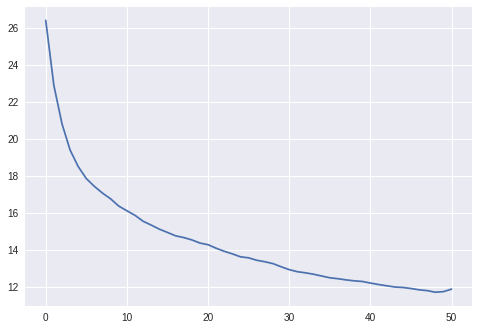

In [19]:
plt.plot(sum_loss)

In [0]:
#Calculating the output from the given input, trained model and layer number
def feedforward(input_data, dnn_output):
    output = dnn_output.eval(feed_dict = {input : input_data})
    
    return output

#Calculating SNR to check model performance  
def calculateSNR(clean_speech , recon_speech , size_recon_sound):
  clean_speech = clean_speech[: size_recon_sound]
  num = np.dot(clean_speech.T , clean_speech)
  den = np.dot((clean_speech - recon_speech).T,(clean_speech - recon_speech))
  SNR = 10 * np.log10(num/den)
#   print('Value of SNR : ' + str(SNR))
  
  return SNR

# Calculating SNR

We will check the performance of the model from the validation data.

In [0]:
SNR = []
for i in range(1200):

  ff_ip = np.array([val_mag_mixed_speech_list[i].T])
  ff_op = feedforward(ff_ip , output)

  speech_complex = np.array([val_mixed_speech_list[i].T])
  shat = np.multiply(ff_op, speech_complex)
  shat = shat.T[:,:,0]
  recon_sound = librosa.istft(shat , hop_length=512 , win_length=1024)
  
  file_num = str(i).zfill(4)
  librosa.output.write_wav('val_recon' + file_num + '.wav', recon_sound, sr = 16000)
  
  clean_speech = librosa.istft(val_clean_speech_list[i] , hop_length=512 , win_length=1024)
  
  size_recon_sound = np.shape(recon_sound)[0]
  
  snr = calculateSNR(clean_speech , recon_sound , size_recon_sound)
  
  SNR.append(snr)

In [22]:
print('Minimum SNR of 1200 files : ' + str(min(SNR)))
print('Mean SNR of 1200 files : ' + str(np.mean(SNR)))
print('Maximum SNR of 1200 files : ' + str(max(SNR)))

Minimum SNR of 1200 files : 4.142335057258606
Mean SNR of 1200 files : 11.19051182071368
Maximum SNR of 1200 files : 26.179444789886475


# Testing

In [0]:
for i in range(400):
  ff_ip = np.array([test_mag_speech_list[i].T])
  ff_op = feedforward(ff_ip , output)

  speech_complex = np.array([test_speech_list[i].T])
  shat = np.multiply(ff_op, speech_complex)
  shat = shat.T[:,:,0]
  recon_sound = librosa.istft(shat , hop_length=512 , win_length=1024)
  
  file_num = str(i).zfill(4)
  librosa.output.write_wav('test_recon' + file_num + '.wav', recon_sound, sr = 16000)
  files.download('test_recon' + file_num + '.wav') 